In [1]:
import pandas as pd 
import numpy as np

import sklearn
import matplotlib.pyplot as plt

from scipy.stats import norm
import statistics
import seaborn as sns
from scipy.stats import f_oneway
import scikit_posthocs as sp
from scipy.stats import kruskal
import statsmodels.stats.multicomp as mc

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score



# Classification
- This notebook will classify the different claims with the help of the significant features.
- We import the computed Liar data frame and conduct several classification algorithms

In [2]:
df_classification = pd.read_csv('/Users/sandrobarreshamers/Thesis_IS_fake_news/ThesisData/Liar_computed_final_version.csv')


In [3]:
df_classification.head()

,Unnamed: 0,json_id,claim,object,binary label,readability,compressed_size,vader_neg,vader_neu,vader_pos,...,pos_NOUN,pos_NUM,pos_PART,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SYM,pos_VERB,pos_X
0,0,10540.json,half-true,When did the decline of coal start? It started...,2,71.815000,11444,0.000,0.902,0.098,...,5.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,4.0,0.0
1,1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",2,71.781579,9089,0.107,0.687,0.206,...,2.0,0.0,1.0,0.0,7.0,3.0,0.0,0.0,3.0,0.0
2,2,1123.json,false,Health care reform legislation is likely to ma...,1,53.655000,5511,0.000,0.606,0.394,...,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3,9028.json,half-true,The economic turnaround started at the end of ...,2,61.325000,4710,0.000,1.000,0.000,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4,12465.json,true,The Chicago Bears have had more starting quart...,0,54.096667,12203,0.119,0.828,0.053,...,5.0,2.0,0.0,0.0,4.0,3.0,1.0,0.0,3.0,0.0


In [12]:
df_classification.columns

Index(['Unnamed: 0', 'json_id', 'claim', 'object', 'binary label',
       'readability', 'compressed_size', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'tot_ner_count', 'ner_counts', 'input_vector_ner',
       'NER_CARDINAL', 'NER_DATE', 'NER_EVENT', 'NER_FAC', 'NER_GPE',
       'NER_LANGUAGE', 'NER_LAW', 'NER_LOC', 'NER_MONEY', 'NER_NORP',
       'NER_ORDINAL', 'NER_ORG', 'NER_PERCENT', 'NER_PERSON', 'NER_PRODUCT',
       'NER_QUANTITY', 'NER_TIME', 'NER_WORK_OF_ART', 'pos counts',
       'input_vector_pos', 'pos_ADJ', 'pos_ADP', 'pos_ADV', 'pos_AUX',
       'pos_CCONJ', 'pos_DET', 'pos_INTJ', 'pos_NOUN', 'pos_NUM', 'pos_PART',
       'pos_PRON', 'pos_PROPN', 'pos_PUNCT', 'pos_SCONJ', 'pos_SYM',
       'pos_VERB', 'pos_X'],
      dtype='object')

### Binary classification
We exclude the 'In Between' labels from the data frame since we will conduct a binary classification.

In [4]:
Liar_computed = df_classification

In [5]:
from faKy import values_by_label, dunn_table
labels = [0, 1, 2]
df_label = 'binary label'

df_Liar_true = Liar_computed[(Liar_computed['binary label'] == 0)]
df_Liar_false = Liar_computed[(Liar_computed['binary label'] == 1)]
df_Liar_between = Liar_computed[(Liar_computed['binary label'] == 2)]

print(len(df_Liar_true))
print(len(df_Liar_false))
print(len(df_Liar_between))
filtered_df = Liar_computed[(Liar_computed['binary label'].isin([0, 1, 2]))]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandrobarreshamers/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


1676
2833
5730


## Classification pre-face
- in this code blocks, we prepare the data and set up the experiment to later classify the False and True label
- Based on the previously conducted KST and Dunn tests, we now train the different models on the significant features
- We divide the data in train and test data
- we instantiate the K-fold cross validation for both the train and test data with k=5

In [393]:
no_feature_selection = ['readability', 'compressed_size', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'tot_ner_count',
       'NER_CARDINAL', 'NER_DATE', 'NER_EVENT', 'NER_FAC', 'NER_GPE',
       'NER_LANGUAGE', 'NER_LAW', 'NER_LOC', 'NER_MONEY', 'NER_NORP',
       'NER_ORDINAL', 'NER_ORG', 'NER_PERCENT', 'NER_PERSON', 'NER_PRODUCT',
       'NER_QUANTITY', 'NER_TIME', 'NER_WORK_OF_ART', 'pos_ADJ', 'pos_ADP', 'pos_ADV', 'pos_AUX',
       'pos_CCONJ', 'pos_DET', 'pos_INTJ', 'pos_NOUN', 'pos_NUM', 'pos_PART',
       'pos_PRON', 'pos_PROPN', 'pos_PUNCT', 'pos_SCONJ', 'pos_SYM',
       'pos_VERB', 'pos_X']

all_significant_features = ['readability', 'compressed_size', 'vader_neg', 'vader_neu', 'tot_ner_count','NER_CARDINAL', 'NER_DATE', 'NER_MONEY', 'NER_ORDINAL', 'NER_ORG', 'NER_PERCENT', 'NER_PERSON','NER_WORK_OF_ART',
                            'pos_ADJ', 'pos_ADP', 'pos_ADV', 'pos_AUX', 'pos_CCONJ', 'pos_DET', 'pos_NOUN', 'pos_NUM', 'pos_PART', 'pos_PROPN', 'pos_PUNCT', 'pos_SCONJ', 'pos_SYM', 'pos_VERB']


three_way_significant_features= ['readability', 'compressed_size','NER_CARDINAL','NER_PERSON','pos_AUX','pos_PART','pos_VERB']


### Train and Test data
- In this code, we divide the code into test and train data. 
- Furthermore, this code snippet performs random oversampling on the training data to address the class imbalance.
- It resamples the training data to increase the number of instances in the minority class by randomly replicating samples. 
- The resampled data is stored in X_train_resampled and y_train_resampled, which can be used for training a machine-learning model

In [394]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


In [395]:
class_counts_init = filtered_df['binary label'].value_counts()
print(f'Initial number of train instances: \nLabel : 0(True), counts:{class_counts_init[0]}\nLabel: 1(False), counts:{class_counts_init[1]}\nLabel: 2(IB), counts:{class_counts_init[2]}\n')

class_counts_over = pd.Series(y_train_resampled).value_counts()
print(f'Number of train instances after oversampling: \nLabel : 0(True), counts:{class_counts_over[0]}\nLabel: 1(False), counts:{class_counts_over[1]}\nLabel: 2(IB), counts:{class_counts_over[2]}\n')


Initial number of train instances: 
Label : 0(True), counts:1676
Label: 1(False), counts:2833
Label: 2(IB), counts:5730

Number of train instances after oversampling: 
Label : 0(True), counts:4565
Label: 1(False), counts:4565
Label: 2(IB), counts:4565



In [396]:
data = {
    'Label': [0, 1, 2],
    'Class': ['True', 'False', 'IB'],
    'Counts (initial)': [class_counts_init[0], class_counts_init[1], class_counts_init[2]],
    'Counts (after oversampling)': [class_counts_over[0], class_counts_over[1], class_counts_over[2]],
}
df = pd.DataFrame(data)

latex_table = df.to_latex(index=False)

print(latex_table)


\begin{tabular}{rlrr}
\toprule
 Label & Class &  Counts (initial) &  Counts (after oversampling) \\
\midrule
     0 &  True &              1676 &                         4565 \\
     1 & False &              2833 &                         4565 \\
     2 &    IB &              5730 &                         4565 \\
\bottomrule
\end{tabular}



/var/folders/0q/8tgppr255xx8v40x26xhhmhr0000gn/T/ipykernel_11785/164673920.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False)


In [397]:
import sklearn.metrics as metrics
kfold_train = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_test = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='macro')

## Classification Algorithms
- In the following code blocks, we perform the three ML classification algorithms discussed in the research paper; the three models are:
  - Naive Bias
  - Random Forest
  - Gradient Booster 
  - Dummy classifier
  
- The three models are trained and evaluated on the three feature inputs
  - No feature selection
  - Two-way significant feature selection
  - Three-way significant feature selection

## Naive Bayes

### Naive Bayes no feature selection

In [398]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df[no_feature_selection]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

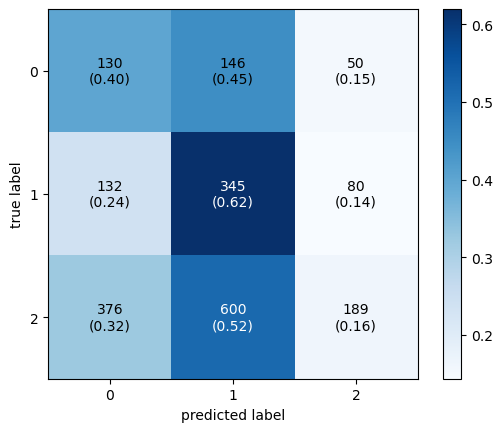

In [399]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm_NB_all =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_NB_all,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [400]:
# Train
scores_NB_train_no_feature_selection = cross_val_score(nb_model, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold crss training data no feature selection: %0.2f, cv:(+/- %0.2f)" % (scores_NB_train_no_feature_selection.mean(), 
                                                            (scores_NB_train_no_feature_selection.std()/scores_NB_train_no_feature_selection.mean())))

# Test
scores_NB_test_no_feature_selection = cross_val_score(nb_model, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data no feature selection: %0.2f, cv:(+/- %0.2f)" % (scores_NB_test_no_feature_selection.mean(), 
                                                            (scores_NB_test_no_feature_selection.std()/scores_NB_test_no_feature_selection.mean())))

f1 score k fold crss training data no feature selection: 0.38, cv:(+/- 0.02)
f1 score k fold cross for the test data no feature selection: 0.34, cv:(+/- 0.10)


### Naive Bayes Two-way significant

In [401]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df[all_significant_features]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
class_counts_init = filtered_df['binary label'].value_counts()

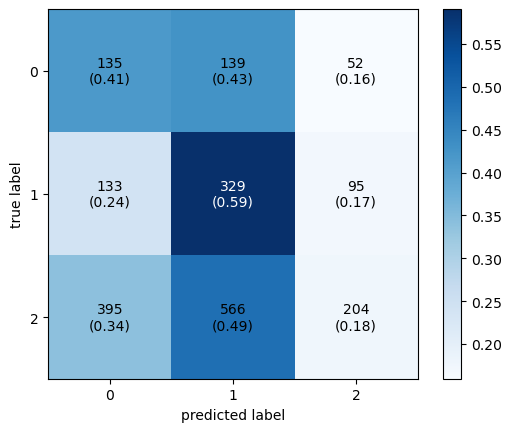

In [402]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm_NB_s =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_NB_s,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [403]:
# Train
scores_NB_train_significant_feature_selection = cross_val_score(nb_model, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold crss training data significant feature selection: %0.2f, cv:(+/- %0.2f)" % (scores_NB_train_significant_feature_selection.mean(), 
                                                            (scores_NB_train_significant_feature_selection.std()/scores_NB_train_significant_feature_selection.mean())))

# Test
scores_NB_test_significant_feature_selection = cross_val_score(nb_model, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data significant feature selection: %0.2f, cv:(+/- %0.2f)" % (scores_NB_train_significant_feature_selection.mean(), 
                                                            (scores_NB_train_significant_feature_selection.std()/scores_NB_train_significant_feature_selection.mean())))

f1 score k fold crss training data significant feature selection: 0.38, cv:(+/- 0.03)
f1 score k fold cross for the test data significant feature selection: 0.38, cv:(+/- 0.03)


### Naive Bayes Three-way significant

In [404]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df[three_way_significant_features]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
class_counts_init = filtered_df['binary label'].value_counts()

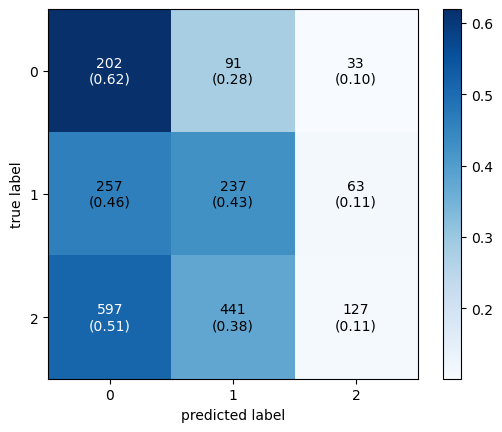

In [405]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm_NB_three =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_NB_three,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [406]:
# Train
scores_NB_train_three_significant_feature_selection = cross_val_score(nb_model, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold crss training data three way significant feature selection: %0.2f, cv:(+/- %0.2f)" % (scores_NB_train_three_significant_feature_selection.mean(), 
                                                            (scores_NB_train_three_significant_feature_selection.std()/scores_NB_train_three_significant_feature_selection.mean())))

# Test
scores_NB_test_three_significant_feature_selection = cross_val_score(nb_model, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data three way significant feature selection: %0.2f, cv:(+/- %0.2f)" % (scores_NB_test_three_significant_feature_selection.mean(), 
                                                            (scores_NB_test_three_significant_feature_selection.std()/scores_NB_test_three_significant_feature_selection.mean())))

f1 score k fold crss training data three way significant feature selection: 0.36, cv:(+/- 0.02)
f1 score k fold cross for the test data three way significant feature selection: 0.28, cv:(+/- 0.10)


## Random forrest

### Random forrest no feature selection

In [407]:
X = filtered_df[no_feature_selection]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


[[ 48  83 195]
 [ 62 144 351]
 [148 274 743]]


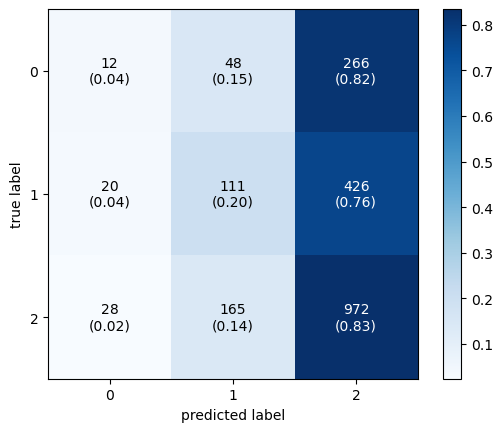

In [408]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)


cm_RF_all =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_RF_all,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

print(cm_RF)

In [409]:
# Train
scores_RF_train_no_feature_selection = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross training data no feature selection: %0.2f (+/- %0.2f)" % (scores_RF_train_no_feature_selection.mean(), 
                                                            (scores_RF_train_no_feature_selection.std()/scores_RF_train_no_feature_selection.mean())))

#Test
scores_RF_test_no_feature_selection = cross_val_score(clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data no feature selection : %0.2f (+/- %0.2f)" % (scores_RF_test_no_feature_selection.mean(), 
                                                            (scores_RF_test_no_feature_selection.std()/scores_RF_test_no_feature_selection.mean())))

f1 score k fold cross training data no feature selection: 0.84 (+/- 0.01)
f1 score k fold cross for the test data no feature selection : 0.30 (+/- 0.05)


### Random forrest Two-way significant

In [410]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df[all_significant_features]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

[[ 48  83 195]
 [ 62 144 351]
 [148 274 743]]


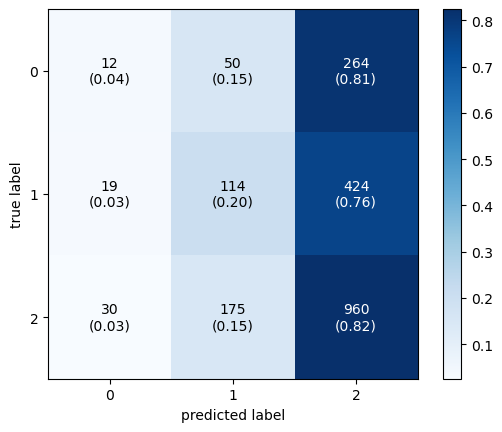

In [411]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)


cm_RF_s =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_RF_s,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

print(cm_RF)

In [412]:
# Train
scores_RF_train_significant_feature_selection = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross training data significant feature selection: %0.2f (+/- %0.2f)" % (scores_RF_train_significant_feature_selection.mean(), 
                                                            (scores_RF_train_significant_feature_selection.std()/scores_RF_train_significant_feature_selection.mean())))

#Test
scores_RF_test_significant_feature_selection = cross_val_score(clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data significant feature selection: %0.2f (+/- %0.2f)" % (scores_RF_test.mean(), 
                                                            (scores_RF_test.std()/scores_RF_test.mean())))

f1 score k fold cross training data significant feature selection: 0.83 (+/- 0.00)
f1 score k fold cross for the test data significant feature selection: 0.34 (+/- 0.03)


### Random Foorest Three-way significant

In [413]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df[three_way_significant_features]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

[[ 48  83 195]
 [ 62 144 351]
 [148 274 743]]


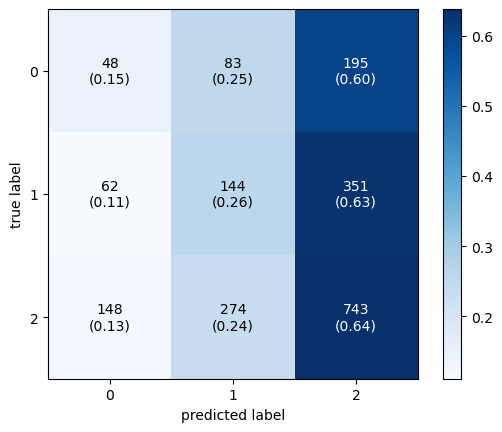

In [414]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)


cm_RF_three =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_RF_three,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

print(cm_RF)

In [415]:
# Train
scores_RF_train_three_significant_feature_selection = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross training data three way significant feature selection: %0.2f (+/- %0.2f)" % (scores_RF_train_three_significant_feature_selection.mean(), 
                                                            (scores_RF_train_three_significant_feature_selection.std()/scores_RF_train_three_significant_feature_selection.mean())))

#Test
scores_RF_test_three_significant_feature_selection = cross_val_score(clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data three way significant feature selection: %0.2f (+/- %0.2f)" % (scores_RF_test_three_significant_feature_selection.mean(), 
                                                            (scores_RF_test_three_significant_feature_selection.std()/scores_RF_test_three_significant_feature_selection.mean())))

f1 score k fold cross training data three way significant feature selection: 0.78 (+/- 0.01)
f1 score k fold cross for the test data three way significant feature selection: 0.34 (+/- 0.03)


## Gradient Booster

### Gradien Booster no feature selection

In [416]:
X = filtered_df[no_feature_selection]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


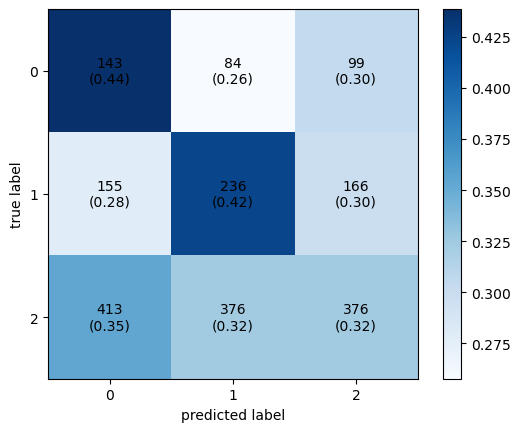

In [417]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.08, max_depth=2, subsample=0.5, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)
y_pred = gb_clf.predict(X_test)
cm_GB_all = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_GB_all,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [418]:
#Train
scores_GB_train_no_feature_selection = cross_val_score(gb_clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold corss train no feature selection:%0.2f cf:(+/- %0.2f)" % (scores_GB_train_no_feature_selection.mean(), 
                                                            (scores_GB_train_no_feature_selection.std()/scores_GB_train_no_feature_selection.mean())))

#Test
scores_GB_test_no_feature_selection = cross_val_score(gb_clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data no feature selectio: %0.2f cf:(+/- %0.2f)" % (scores_GB_test_no_feature_selection.mean(), 
                                                            (scores_GB_test_no_feature_selection.std()/scores_GB_test_no_feature_selection.mean())))

f1 score k fold corss train no feature selection:0.45 cf:(+/- 0.03)
f1 score k fold cross for the test data no feature selectio: 0.28 cf:(+/- 0.06)


### Gradient Booster Two-way significant 

In [419]:
X = filtered_df[all_significant_features]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)




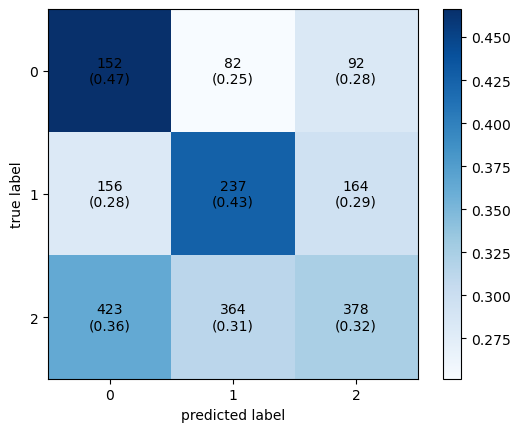

In [420]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.08, max_depth=2, subsample=0.5, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)
y_pred = gb_clf.predict(X_test)
cm_GB_s = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_GB_s,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [421]:
#Train
scores_GB_train_significant_feature_selection = cross_val_score(gb_clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold corss train significant feature selection:%0.2f cf:(+/- %0.2f)" % (scores_GB_train_significant_feature_selection.mean(), 
                                                            (scores_GB_train_significant_feature_selection.std()/scores_GB_train_significant_feature_selection.mean())))

#Test
scores_GB_test_significant_feature_selection = cross_val_score(gb_clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data significant feature selection: %0.2f cf:(+/- %0.2f)" % (scores_GB_test_significant_feature_selection.mean(), 
                                                            (scores_GB_test_significant_feature_selection.std()/scores_GB_test_significant_feature_selection.mean())))

f1 score k fold corss train significant feature selection:0.45 cf:(+/- 0.02)
f1 score k fold cross for the test data significant feature selection: 0.27 cf:(+/- 0.03)


### Gradient Booster Three-way significant 

In [422]:
X = filtered_df[three_way_significant_features]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)




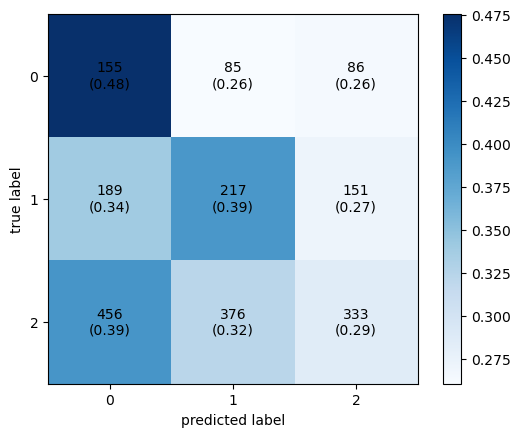

In [423]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.08, max_depth=2, subsample=0.5, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)
y_pred = gb_clf.predict(X_test)
cm_GB_three = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_GB_three,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [424]:
#Train
scores_GB_train_three_significant_feature_selection = cross_val_score(gb_clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold corss train three way signifance feature selection :%0.2f cf:(+/- %0.2f)" % (scores_GB_train_three_significant_feature_selection.mean(), 
                                                            (scores_GB_train_three_significant_feature_selection.std()/scores_GB_train_three_significant_feature_selection.mean())))

#Test
scores_GB_test_three_significant_feature_selection = cross_val_score(gb_clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data three way signifance feature selection: %0.2f cf:(+/- %0.2f)" % (scores_GB_test_three_significant_feature_selection.mean(), 
                                                            (scores_GB_test_three_significant_feature_selection.std()/scores_GB_test_three_significant_feature_selection.mean())))

f1 score k fold corss train three way signifance feature selection :0.42 cf:(+/- 0.01)
f1 score k fold cross for the test data three way signifance feature selection: 0.27 cf:(+/- 0.04)


### Baseline

In [425]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
y_pred_uniform = dummy_clf.predict(X_test)
accuracy_stratified = accuracy_score(y_test, y_pred_stratified)


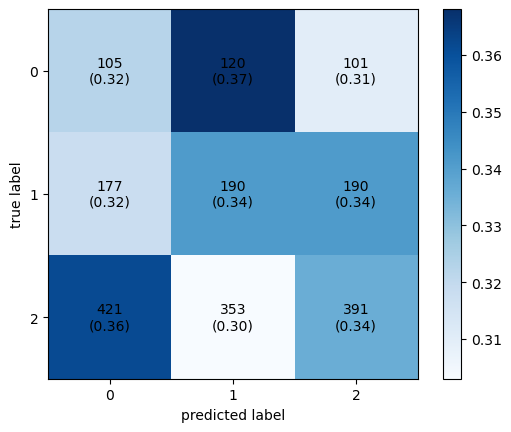

In [426]:
cm_dummy =confusion_matrix(y_test, y_pred_uniform)
fig, ax = plot_confusion_matrix(conf_mat=cm_dummy,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)



In [427]:
# Train
scores_Dummy_train = cross_val_score(dummy_clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross training data:%0.2f (+/- %0.2f)" % (scores_Dummy_train.mean(), scores_Dummy_train.std()))

#Test
scores_Dummy_test = cross_val_score(dummy_clf, X_test, y_test, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores_Dummy_test.mean(), scores_Dummy_test.std()))

f1 score k fold cross training data:0.34 (+/- 0.01)
f1 score k fold cross for the test data: 0.31 (+/- 0.02)


# Evaluation
- In this code block, the different classification ML models are evaluated and compared against each other
- Subsequently, the evaluation is displayed in a table and later printed in latex format
- this latex format is used in the research paper

In [434]:
metrics = ['F1 Score Test', 'Relative Improvement']
model_names = ['Naive Bayes', 'Naive Bayes', 'Naive Bayes',
               'Random Forrest', 'Random Forrest', 'Random Forrest',
               'Gradient Booster', 'Gradient Booster', 'Gradient Booster',
               'Dummy Classifier Uniform']

feature_selection = ['no', 'two-way significant', 'three-way significant',
                      'no', 'two-way significant', 'three-way significant',
                      'no', 'two-way significant', 'three-way significant',
                      '']

# based on higest score
Relative_Improvement_NB_nf = (np.mean(scores_NB_test_no_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_NB_f = (np.mean(scores_NB_test_significant_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_NB_three_f = (np.mean(scores_NB_test_three_significant_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100

Relative_Improvement_RF_nf = (np.mean(scores_GB_test_no_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_RF_f = (np.mean(scores_RF_test_significant_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_RF_three_f = (np.mean(scores_RF_test_three_significant_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100

Relative_Improvement_GB_nf = (np.mean(scores_GB_test_no_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_GB_f = (np.mean(scores_GB_test_significant_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_GB_three_f = (np.mean(scores_GB_test_three_significant_feature_selection)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100

Relative_Improvement_DC = (np.mean(scores_Dummy_test)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100

# Aggregating results
scores_NB_nf = [np.mean(scores_NB_test_no_feature_selection) * 100, np.mean(scores_NB_train_no_feature_selection) * 100, cm_NB_all[0,0], cm_NB_all[0,1], cm_NB_all[1,0], cm_NB_all[1,1], Relative_Improvement_NB_nf]
scores_NB_f = [np.mean(scores_NB_test_significant_feature_selection) * 100, np.mean(scores_NB_train_significant_feature_selection) * 100, cm_NB_s[0,0], cm_NB_s[0,1], cm_NB_s[1,0], cm_NB_s[1,1], Relative_Improvement_NB_f]
scores_NB_three_f = [np.mean(scores_NB_test_three_significant_feature_selection) * 100, np.mean(scores_NB_train_three_significant_feature_selection) * 100, cm_NB_three[0,0], cm_NB_three[0,1], cm_NB_three[1,0], cm_NB_three[1,1], Relative_Improvement_NB_three_f]


scores_RF_nf = [np.mean(scores_RF_test_no_feature_selection) * 100, np.mean(scores_RF_train_no_feature_selection) * 100, cm_RF_all[0,0], cm_RF_all[0,1], cm_RF_all[1,0], cm_RF_all[1,1], Relative_Improvement_RF_nf]
scores_RF_f = [np.mean(scores_RF_test_significant_feature_selection) * 100, np.mean(scores_RF_train_significant_feature_selection) * 100, cm_RF_s[0,0], cm_RF_s[0,1], cm_RF_s[1,0], cm_RF_s[1,1], Relative_Improvement_RF_f]
scores_RF_three_f = [np.mean(scores_RF_test_three_significant_feature_selection) * 100, np.mean(scores_RF_train_three_significant_feature_selection) * 100, cm_RF_three[0,0], cm_RF_three[0,1], cm_RF_three[1,0], cm_RF_three[1,1], Relative_Improvement_RF_three_f]


scores_GB_nf = [np.mean(scores_GB_test_no_feature_selection) * 100, np.mean(scores_GB_train_no_feature_selection) * 100, cm_GB_all[0,0], cm_GB_all[0,1], cm_GB_all[1,0], cm_GB_all[1,1], Relative_Improvement_GB_nf]
scores_GB_f = [np.mean(scores_GB_test_significant_feature_selection) * 100, np.mean(scores_GB_train_significant_feature_selection) * 100, cm_GB_s[0,0], cm_GB_s[0,1], cm_GB_s[1,0], cm_GB_s[1,1], Relative_Improvement_GB_f]
scores_GB_three_f = [np.mean(scores_GB_test_three_significant_feature_selection) * 100, np.mean(scores_GB_train_three_significant_feature_selection) * 100, cm_GB_three[0,0], cm_GB_three[0,1], cm_GB_three[1,0], cm_GB_three[1,1], Relative_Improvement_GB_three_f]

scores_DC = [np.mean(scores_Dummy_test) * 100, np.mean(scores_Dummy_train) * 100, cm_dummy[0,0], cm_dummy[0,1], cm_dummy[1,0], cm_dummy[1,1], Relative_Improvement_DC]


eval_df = pd.DataFrame({
    'Model': model_names,
    'Feature Selection': feature_selection,
    'F1 Score Test (%)': [f"{np.mean(scores_NB_test_no_feature_selection) * 100:.2f} (+/- {(scores_NB_test_no_feature_selection.std()/scores_NB_test_no_feature_selection.mean()) * 100:.2f})",
                          f"{np.mean(scores_NB_test_significant_feature_selection) * 100:.2f} (+/- {(scores_NB_test_significant_feature_selection.std()/scores_NB_test_significant_feature_selection.mean()) * 100:.2f})",
                          f"{np.mean(scores_NB_test_three_significant_feature_selection) * 100:.2f} (+/- {(scores_NB_test_three_significant_feature_selection.std()/scores_NB_test_three_significant_feature_selection.mean()) * 100:.2f})",
                          
                          f"{np.mean(scores_RF_test_no_feature_selection) * 100:.2f} (+/- {(scores_RF_test_no_feature_selection.std()/scores_RF_test_no_feature_selection.mean()) * 100:.2f})",
                          f"{np.mean(scores_RF_test_significant_feature_selection) * 100:.2f} (+/- {(scores_RF_test_significant_feature_selection.std()/scores_RF_test_significant_feature_selection.mean()) * 100:.2f})",
                          f"{np.mean(scores_RF_test_three_significant_feature_selection) * 100:.2f} (+/- {(scores_RF_test_three_significant_feature_selection.std()/scores_RF_test_three_significant_feature_selection.mean()) * 100:.2f})",
                          
                          f"{np.mean(scores_GB_test_no_feature_selection) * 100:.2f} (+/- {(scores_GB_test_no_feature_selection.std()/scores_GB_test_no_feature_selection.mean()) * 100:.2f})",
                          f"{np.mean(scores_GB_test_significant_feature_selection) * 100:.2f} (+/- {(scores_GB_test_significant_feature_selection.std()/scores_GB_test_significant_feature_selection.mean()) * 100:.2f})",
                          f"{np.mean(scores_GB_test_three_significant_feature_selection) * 100:.2f} (+/- {(scores_GB_test_three_significant_feature_selection.std()/scores_GB_test_three_significant_feature_selection.mean()) * 100:.2f})",
                          
                          f"{np.mean(scores_Dummy_test) * 100:.2f} (+/- {(scores_Dummy_test.std()/scores_Dummy_test.mean()) * 100:.2f})"],
    'F1 Score Train (%)': [f"{np.mean(scores_NB_train_no_feature_selection) * 100:.2f} (+/- {(scores_NB_train_no_feature_selection.std()/scores_NB_train_no_feature_selection.mean()) * 100:.2f})",
                           f"{np.mean(scores_NB_train_significant_feature_selection) * 100:.2f} (+/- {(scores_NB_train_significant_feature_selection.std()/scores_NB_train_significant_feature_selection.mean()) * 100:.2f})",
                           f"{np.mean(scores_NB_train_three_significant_feature_selection) * 100:.2f} (+/- {(scores_NB_train_three_significant_feature_selection.std()/scores_NB_train_three_significant_feature_selection.mean()) * 100:.2f})",
                           
                           f"{np.mean(scores_RF_train_no_feature_selection) * 100:.2f} (+/- {(scores_RF_train_no_feature_selection.std()/scores_RF_train_no_feature_selection.mean()) * 100:.2f})",
                           f"{np.mean(scores_RF_train_significant_feature_selection) * 100:.2f} (+/- {(scores_RF_train_significant_feature_selection.std()/scores_RF_train_significant_feature_selection.mean()) * 100:.2f})",
                           f"{np.mean(scores_RF_train_three_significant_feature_selection) * 100:.2f} (+/- {(scores_RF_train_three_significant_feature_selection.std()/scores_RF_train_three_significant_feature_selection.mean()) * 100:.2f})",
                           
                           f"{np.mean(scores_GB_train_no_feature_selection) * 100:.2f} (+/- {(scores_GB_train_no_feature_selection.std()/scores_GB_train_no_feature_selection.mean()) * 100:.2f})",
                           f"{np.mean(scores_GB_train_significant_feature_selection) * 100:.2f} (+/- {(scores_GB_train_significant_feature_selection.std()/scores_GB_train_significant_feature_selection.mean()) * 100:.2f})",
                           f"{np.mean(scores_GB_train_three_significant_feature_selection) * 100:.2f} (+/- {(scores_GB_train_three_significant_feature_selection.std()/scores_GB_train_three_significant_feature_selection.mean()) * 100:.2f})",
                           f"{np.mean(scores_Dummy_train) * 100:.2f} (+/- {(scores_Dummy_train.std()/scores_Dummy_train.mean()) * 100:.2f})"],
    'TP': [scores_NB_nf[2], scores_RF_nf[2], scores_GB_nf[2], scores_NB_f[2], scores_RF_f[2], scores_GB_f[2], scores_NB_three_f[2], scores_RF_three_f[2], scores_GB_three_f[2],scores_DC[2]],
    'FP': [scores_NB_nf[3], scores_RF_nf[3], scores_GB_nf[3], scores_NB_f[3], scores_RF_f[3], scores_GB_f[3], scores_NB_three_f[3], scores_RF_three_f[3], scores_GB_three_f[3], scores_DC[3]],
    'FN': [scores_NB_nf[4], scores_RF_nf[4], scores_GB_nf[4], scores_NB_f[4], scores_RF_f[4], scores_GB_f[4], scores_NB_three_f[4], scores_RF_three_f[4], scores_GB_three_f[4], scores_DC[4]],
    'TN': [scores_NB_nf[5], scores_RF_nf[5], scores_GB_nf[5], scores_NB_f[5], scores_RF_f[5], scores_GB_f[5], scores_NB_three_f[5], scores_RF_three_f[5], scores_GB_three_f[5], scores_DC[5]],
    'Relative Improvement (%)': [round(scores_NB_nf[6], 2),round(scores_NB_f[6], 2),round(scores_NB_three_f[6], 2),round(scores_RF_nf[6], 2),round(scores_RF_f[6], 2),round(scores_RF_three_f[6], 2),round(scores_GB_nf[6], 2),round(scores_GB_f[6], 2),round(scores_GB_three_f[6], 2), round(scores_DC[6],2)]
})



eval_df.set_index('Model', inplace=True)

print(eval_df)


                              Feature Selection  F1 Score Test (%)  \
Model                                                                
Naive Bayes                                  no   34.18 (+/- 9.95)   
Naive Bayes                 two-way significant   36.23 (+/- 6.23)   
Naive Bayes               three-way significant  27.81 (+/- 10.44)   
Random Forrest                               no   30.21 (+/- 4.65)   
Random Forrest              two-way significant   28.66 (+/- 2.23)   
Random Forrest            three-way significant   33.86 (+/- 2.71)   
Gradient Booster                             no   27.88 (+/- 5.52)   
Gradient Booster            two-way significant   27.02 (+/- 2.53)   
Gradient Booster          three-way significant   26.69 (+/- 3.87)   
Dummy Classifier Uniform                          30.67 (+/- 6.73)   

                         F1 Score Train (%)   TP   FP   FN   TN  \
Model                                                             
Naive Bayes              

In [433]:
latex_table_ML_eval = eval_df.to_latex(index=True, float_format=lambda x: "%.2f" % x)
print(latex_table_ML_eval)

\begin{tabular}{lllr}
\toprule
{} &      Feature Selection &  F1 Score Test (\%) &  Relative Improvement (\%) \\
Model                    &                        &                    &                           \\
\midrule
Naive Bayes              &                     no &   34.18 (+/- 9.95) &                     11.42 \\
Naive Bayes              &    two-way significant &   36.23 (+/- 6.23) &                     18.13 \\
Naive Bayes              &  three-way significant &  27.81 (+/- 10.44) &                     -9.34 \\
Random Forrest           &                     no &   30.21 (+/- 4.65) &                     -9.11 \\
Random Forrest           &    two-way significant &   28.66 (+/- 2.23) &                     -6.56 \\
Random Forrest           &  three-way significant &   33.86 (+/- 2.71) &                     10.40 \\
Gradient Booster         &                     no &   27.88 (+/- 5.52) &                     -9.11 \\
Gradient Booster         &    two-way significant &   27.02 (+

/var/folders/0q/8tgppr255xx8v40x26xhhmhr0000gn/T/ipykernel_11785/3099801597.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_ML_eval = eval_df.to_latex(index=True, float_format=lambda x: "%.2f" % x)


### End of notebook